In [1]:
import sys
sys.path.append('..')

In [2]:
from functools import partial
from tempfile import TemporaryDirectory
from pathlib import Path
from textwrap import fill

import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from tests.raster_processing.clip_test import raster_path as SMALL_RASTER_PATH
from eis_toolkit.raster_processing.distance_to_anomaly import distance_to_anomaly, _fits_criteria, distance_to_anomaly_gdal

/home/nialov/.cache/pypoetry/virtualenvs/eis-toolkit-14Bnyb2Y-py3.10/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
def _plot_image(ax, data, title, transform):
    plot.show(data, transform=transform, ax=ax)
    ax.set_title(fill(title, width=25))
    norm = plt.Normalize(vmax=np.nanmax(data), vmin=np.nanmin(data))
    cmap = matplotlib.cm.viridis
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    

0...10...20...30...40...50...60...70...80...90...

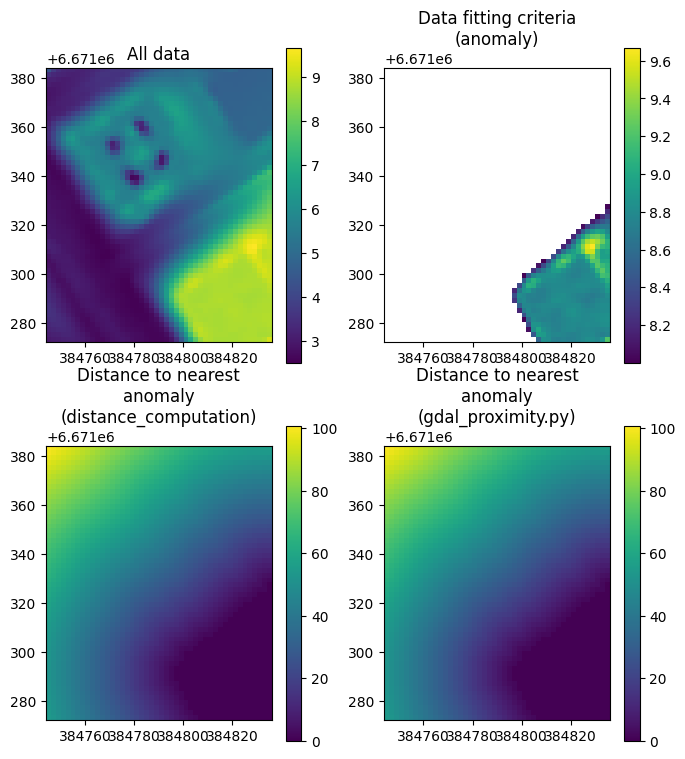

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(8, 9))
axes = axes.flatten()
threshold_criteria_value = 8.0
threshold_criteria = "higher"

with rasterio.open(SMALL_RASTER_PATH) as raster:
    raster_data = raster.read(1)
    raster_profile = raster.profile
raster_transform = raster_profile["transform"]

_plot_image = partial(_plot_image, transform=raster_transform)

_plot_image(ax=axes[0], data=raster_data, title="All data")

raster_data_fits_criteria = _fits_criteria(threshold_criteria_value=threshold_criteria_value, threshold_criteria=threshold_criteria, anomaly_raster_data=raster_data)
raster_data_criteria = np.where(raster_data_fits_criteria, raster_data, np.nan)
_plot_image(ax=axes[1], data=raster_data_criteria, title="Data fitting criteria (anomaly)")

distance_matrix = distance_to_anomaly(
    raster_profile=raster_profile,
    anomaly_raster_data=raster_data,
    anomaly_raster_profile=raster_profile,
    threshold_criteria_value=threshold_criteria_value,
    threshold_criteria=threshold_criteria,
)
_plot_image(ax=axes[2], data=distance_matrix, title="Distance to nearest anomaly (distance_computation)")

with TemporaryDirectory() as tmp_dir_str:
    distance_path = Path(tmp_dir_str) / "distance_to_anomaly_gdal.tif"
    try:
        distance_path = distance_to_anomaly_gdal(
            anomaly_raster_data=raster_data,
            anomaly_raster_profile=raster_profile,
            threshold_criteria_value=threshold_criteria_value,
            threshold_criteria=threshold_criteria,
            output_path=distance_path,
        )
        with rasterio.open(distance_path) as distance_raster:
            _plot_image(ax=axes[3], data=distance_raster.read(1), title="Distance to nearest anomaly (gdal_proximity.py)")
    except ModuleNotFoundError as exc:
        print("distance_to_anomaly_gdal does not work on windows.")
        print(exc)